# 0. Imports and setup

In [60]:
import numpy as np
from numpy import genfromtxt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm.notebook import tqdm
from datetime import datetime
import scipy.stats


from PIL import Image
import glob

# MATLAB (Octave) setup
# Add m functions to the path

from oct2py import octave
octave.addpath('E:/dev/Fall23Project/src/MMA_SurrOpt_2023/')

# Template for running .m file
# octave.eval("""function [a, b] = toto(c);
#     a = c;
#     b = c + 1;
# end""")
# a,b = octave.eval("toto(3, nout =2)")
# a,b = octave.toto(3, nout = 2)
# print(a,b)


'.;E:\\dev\\Fall23Project\\src\\MMA_SurrOpt_2023;C:\\Program Files\\GNU Octave\\Octave-8.4.0\\mingw64\\lib\\octave\\packages\\image-2.14.0\\x86_64-w64-mingw32-api-v58;C:\\Program Files\\GNU Octave\\Octave-8.4.0\\mingw64\\share\\octave\\packages\\image-2.14.0;C:\\Users\\pitipatw\\miniconda3\\envs\\myvae\\Lib\\site-packages\\oct2py;C:\\Users\\pitipatw\\miniconda3\\envs\\myvae\\Lib\\site-packages\\octave_kernel;C:\\Program Files\\GNU Octave\\Octave-8.4.0\\mingw64\\lib\\octave\\8.4.0\\site\\oct\\x86_64-w64-mingw32;C:\\Program Files\\GNU Octave\\Octave-8.4.0\\mingw64\\lib\\octave\\site\\oct\\api-v58\\x86_64-w64-mingw32;C:\\Program Files\\GNU Octave\\Octave-8.4.0\\mingw64\\lib\\octave\\site\\oct\\x86_64-w64-mingw32;C:\\Program Files\\GNU Octave\\Octave-8.4.0\\mingw64\\share\\octave\\8.4.0\\site\\m;C:\\Program Files\\GNU Octave\\Octave-8.4.0\\mingw64\\share\\octave\\site\\api-v58\\m;C:\\Program Files\\GNU Octave\\Octave-8.4.0\\mingw64\\share\\octave\\site\\m;C:\\Program Files\\GNU Octave\\Oct

## 0.1 Test torch 🔋

In [61]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[2.3294e-03, 7.4609e-02, 3.6800e-01],
        [9.4691e-01, 1.6609e-01, 3.5567e-01],
        [5.5075e-01, 2.9004e-04, 8.4598e-02],
        [9.2792e-01, 2.5243e-01, 7.7641e-01],
        [9.7559e-01, 9.1263e-01, 8.6423e-01]])


## 1. Load data

In [62]:
# Initialize the container
design_vectors = [] # 
blfs = []

# path to the dataset (png files)
# path = 'E:\dev\Fall23Project\dataset/*.png'
# path_dummy = 'E:\dev\Fall23Project\dataset_dummy/*.png'
path_buckling = "E:\dev\Fall23Project\dataset\Images/*.png"

# load buckling vector to the dataset.
blf_vector = genfromtxt("E:\dev\Fall23Project\dataset\log.csv", delimiter=',')

#define new sizes
new_size = (256,64)
for filename in glob.glob(path_buckling):
    # get idx, which is the filename without .png
    idx = filename.split("\\")[-1].strip(".png")

    #Match the filename to the blf.
    blf_val = blf_vector[int(idx)-1]

    # image conversion to color
    im=Image.open(filename).convert('L')

    # resize with the new_size
    im = im.resize(new_size, resample=0) 
    
    # Normalize to be in between [0,1] and turn to array
    im_array = np.expand_dims(np.array(im).astype(np.float32)/255, axis = 0)

    #Flatten the image to a 1D vector
    im_array_flatten = im_array.reshape(256*64)  # flatten x  shape[0] is the batch size, -1 is the last dimension of x

    #append the blf value into the 1D image vector.
    thisvector = np.append(im_array_flatten,blf_val)

    #append "this" design_vector into design_vectors
    design_vectors.append(thisvector)#


Recheck out input

In [63]:
print("All input shapes")
design_vectors = np.array(design_vectors)
print(design_vectors.shape)

print("Each image shape")
print(design_vectors[0][:-1].reshape(new_size).shape)
print(max(design_vectors[0][:-1]))

All input shapes
(359, 16385)
Each image shape
(256, 64)
1.0


2


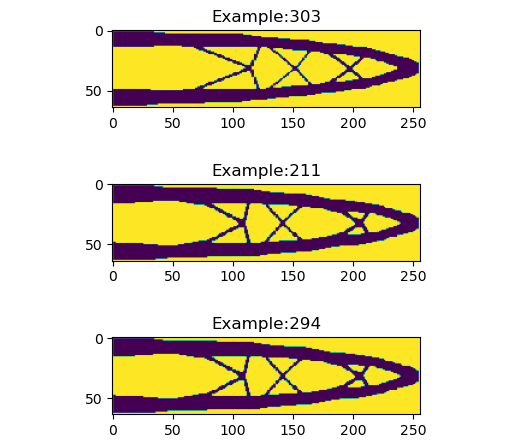

In [64]:
n = 3

fig = plt.figure()

plt.axis('off') 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1)

np.random.seed(seed=1234) #for reproducibility
for i in range(1,n+1):
    fig.add_subplot(n, 1, i) 

    idx = np.random.randint(0, len(design_vectors))
    plt.imshow(design_vectors[idx,:-1].reshape(64,256))
    plt.title("Example:"+ str(idx)) 

np.random.seed(seed=None)
print(np.random.randint(10))



In [65]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64

print("\nTotal datapoints")
print(len(design_vectors))

# Training 70%, Validation 30%
training_set = design_vectors[:int(len(design_vectors)*0.7)]
validation_set = design_vectors[int(len(design_vectors)*0.7)+1:]


print("\nTraining Set shape")
print(training_set.shape)
print("\nValidation Images")
print(validation_set.shape)

# turn into tensors -> compatibal format for Dataloader.
training_set = torch.Tensor(training_set)
training_set = np.array(training_set)
training_dataloader = DataLoader(training_set, shuffle= True, batch_size = batch_size) # create your dataloader

validation_set = torch.Tensor(validation_set)
validation_set = np.array(validation_set)
validation_dataloader = DataLoader(validation_set, shuffle= True, batch_size = batch_size) # create your dataloader



Total datapoints
359

Training Set shape
(251, 16385)

Validation Images
(107, 16385)


## 2. Autoencoder

Define a vanila autodencoder


In [66]:
#Overall AutoEncoder consists of encoder and decoder parts
class AutoEncoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

        # can use other losses too, MAE, etc.
        self.loss = torch.nn.MSELoss() 
        # self.loss = torch.nn.L1Loss() 

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def reconstruction_loss(self, input_image, target_image):
        return self.loss(input_image, target_image) 

Encoder Part

In [99]:
class Encoder(torch.nn.Module):
  #we are dealing with images -> use convolutional network.
    def __init__(self, latent_dimensionality=2):
        super(Encoder, self).__init__()
        input_size_flatten = 256*64 + 1

        self.fc_1 = torch.nn.Linear(in_features= input_size_flatten, out_features=1000)
        self.fc_2 = torch.nn.Linear(in_features= 1000, out_features=100)

        #add blf to it, so the size become 100 + 1 
        self.fc_3 = torch.nn.Linear(in_features= 100 + 1 , out_features=latent_dimensionality)
    
    def forward(self, x):
        #pull blf values out (for skip connection)
        blf = torch.unsqueeze(x[...,-1],1)

        # # x is only image values
        # x = x[...,:-1]

        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)

        #We add blf again here
        x = torch.cat([x,blf], dim=-1)
        x = self.fc_3(x)
        
        return x


# the decoder essentially mirrors the architecture of the encoder
class Decoder(torch.nn.Module):
    def __init__(self, latent_dimensionality=2):
        super(Decoder, self).__init__()

        self.fc_1 = torch.nn.Linear(in_features=latent_dimensionality, out_features=100)
        self.fc_2 = torch.nn.Linear(in_features=100, out_features = 1000)
        self.fc_3 = torch.nn.Linear(in_features=1000, out_features = 256*64 + 1)

    
    def forward(self, x):
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)
      
        x1 = torch.sigmoid(x[...,:-1])  # squeeze pixel value between 0 and 1
        x2 = torch.unsqueeze(x[...,-1],1)

        x = torch.cat([x1,x2], dim =-1)

        return x

In [100]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [101]:
ae_model = AutoEncoder(encoder=Encoder(), decoder=Decoder()).to(device)

In [102]:
# summary(ae_model, input_size=(1, 28, 28))
summary(ae_model, input_size=(1,256*64+1))
# summary(ae_model, input_size=(1, 64, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1000]      16,386,000
            Linear-2               [-1, 1, 100]         100,100
            Linear-3                 [-1, 1, 2]             204
           Encoder-4                 [-1, 1, 2]               0
            Linear-5               [-1, 1, 100]             300
            Linear-6              [-1, 1, 1000]         101,000
            Linear-7             [-1, 1, 16385]      16,401,385
           Decoder-8             [-1, 1, 16385]               0
Total params: 32,988,989
Trainable params: 32,988,989
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.27
Params size (MB): 125.84
Estimated Total Size (MB): 126.17
----------------------------------------------------------------


In [103]:
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.001)

torch.Size([64, 1, 16385])


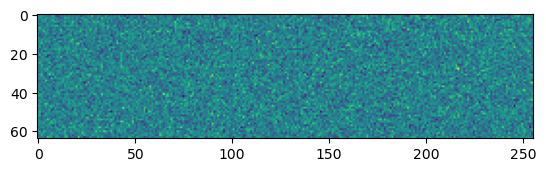

In [104]:
input_tensor = torch.rand(64, 1, 256*64 + 1).to(device)

# Call the autoencoder
output = ae_model(input_tensor)
print(output.size())

imgplot = plt.imshow(output[0,:,:-1].reshape(64,256).detach().cpu().numpy())

In [105]:
training_losses = []
validation_losses = []

In [106]:
n_epochs = 1000
reporting_frequency = 20


for i in tqdm(range(1, n_epochs + 1)):

    # training
    for j, (input_vectors) in enumerate(training_dataloader):
        optimizer.zero_grad() #reset the optimizer in every batch

        input_vectors = input_vectors.to(device)

        reconstructed = ae_model(input_vectors)
        loss = ae_model.reconstruction_loss(reconstructed, input_vectors) #loss between digit and reconstrcted.

        loss.backward()
        optimizer.step()

        training_losses.append(loss.detach().cpu().numpy())
        if (j + 1) % reporting_frequency == 0:
            print(
                "Epoch {0} | Mean training loss after {1} batches: {2:.3f}".format(
                    i, j, np.mean(training_losses)
                )
            )

    #validation
    for j, (input_vectors) in enumerate(validation_dataloader):
        input_vectors = input_vectors.to(device)
        reconstructed = ae_model(input_vectors)
        loss = ae_model.reconstruction_loss(reconstructed, input_vectors)

        validation_losses.append(loss.detach().cpu().numpy())

    print(
        "Epoch {0} | Mean training loss: {1:.3f} | Mean validation loss: {2:.3f}".format(
            i, np.mean(training_losses), np.mean(validation_losses)
        )
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1 | Mean training loss: 0.167 | Mean validation loss: 0.082
Epoch 2 | Mean training loss: 0.121 | Mean validation loss: 0.079
Epoch 3 | Mean training loss: 0.105 | Mean validation loss: 0.077
Epoch 4 | Mean training loss: 0.096 | Mean validation loss: 0.076
Epoch 5 | Mean training loss: 0.090 | Mean validation loss: 0.074
Epoch 6 | Mean training loss: 0.086 | Mean validation loss: 0.073
Epoch 7 | Mean training loss: 0.084 | Mean validation loss: 0.072
Epoch 8 | Mean training loss: 0.081 | Mean validation loss: 0.071
Epoch 9 | Mean training loss: 0.079 | Mean validation loss: 0.070
Epoch 10 | Mean training loss: 0.077 | Mean validation loss: 0.068
Epoch 11 | Mean training loss: 0.074 | Mean validation loss: 0.067
Epoch 12 | Mean training loss: 0.072 | Mean validation loss: 0.065
Epoch 13 | Mean training loss: 0.070 | Mean validation loss: 0.064
Epoch 14 | Mean training loss: 0.068 | Mean validation loss: 0.062
Epoch 15 | Mean training loss: 0.067 | Mean validation loss: 0.061
Epoc

[array(0.24918613, dtype=float32), array(0.20420215, dtype=float32), array(0.12452151, dtype=float32), array(0.0903892, dtype=float32), array(0.08547014, dtype=float32), array(0.0720907, dtype=float32), array(0.07169172, dtype=float32), array(0.07251885, dtype=float32), array(0.07542035, dtype=float32), array(0.07192925, dtype=float32), array(0.06799256, dtype=float32), array(0.07210878, dtype=float32), array(0.07635493, dtype=float32), array(0.06468076, dtype=float32), array(0.06630742, dtype=float32), array(0.07056677, dtype=float32), array(0.06841221, dtype=float32), array(0.06907446, dtype=float32), array(0.06846073, dtype=float32), array(0.06619804, dtype=float32), array(0.06793917, dtype=float32), array(0.07212969, dtype=float32), array(0.06540038, dtype=float32), array(0.06238615, dtype=float32), array(0.06909336, dtype=float32), array(0.06454573, dtype=float32), array(0.06435557, dtype=float32), array(0.06510296, dtype=float32), array(0.06519601, dtype=float32), array(0.0650086

<function matplotlib.pyplot.show(close=None, block=None)>

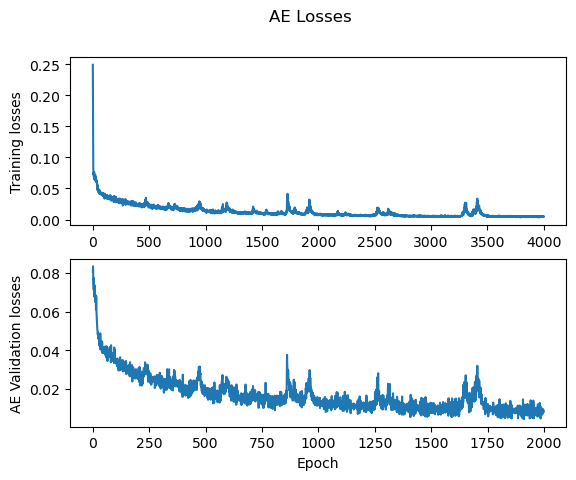

In [107]:
#plot losses
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('AE Losses')

ax1.set_ylabel('Training losses')

print(training_losses)
p1 = ax1.plot(training_losses)

ax2.set_ylabel('AE Validation losses')
ax2.set_xlabel("Epoch")

print(validation_losses)
p2 = ax2.plot(validation_losses)

plt.show

In [108]:
ae_model.eval() #put this to inference mode.

AutoEncoder(
  (encoder): Encoder(
    (fc_1): Linear(in_features=16385, out_features=1000, bias=True)
    (fc_2): Linear(in_features=1000, out_features=100, bias=True)
    (fc_3): Linear(in_features=101, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc_1): Linear(in_features=2, out_features=100, bias=True)
    (fc_2): Linear(in_features=100, out_features=1000, bias=True)
    (fc_3): Linear(in_features=1000, out_features=16385, bias=True)
  )
  (loss): MSELoss()
)

1
tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 6.9034]],
       device='cuda:0', grad_fn=<CatBackward0>)
1
tensor([[1.0000, 0.9879, 0.9934,  ..., 1.0000, 1.0000, 6.3409]],
       device='cuda:0', grad_fn=<CatBackward0>)
1
tensor([[1.0000, 0.9879, 0.9934,  ..., 1.0000, 1.0000, 6.3409]],
       device='cuda:0', grad_fn=<CatBackward0>)


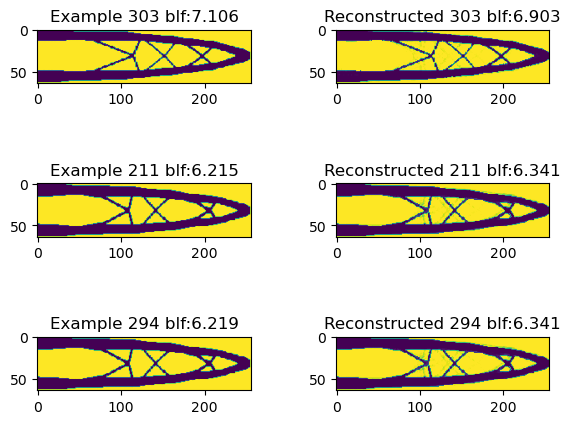

In [109]:
n = 3

fig = plt.figure()
plt.axis('off') 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1)

np.random.seed(seed=1234) #for reproducibility
for i in range(1,n+1):
    fig.add_subplot(n, 2, 2*i-1) 
    idx = np.random.randint(0, len(design_vectors))

    
    design_vector = design_vectors[idx,:]
    image_vector = design_vector[:-1]
    blf_val = design_vector[-1]

    plt.imshow(image_vector.reshape(64,256))
    # plt.title("Example:"+ str(idx) + " blf:" +str(blf_val)) 
    plt.title("Example {0} blf:{1:.3f}".format(idx, blf_val)) 
    fig.add_subplot(n, 2, 2*i) 

    reconstructed_vector = ae_model(torch.tensor(design_vector.astype(np.float32)).to(device).unsqueeze(0))
    print(len(reconstructed_vector))
    print(reconstructed_vector)
    reconstructed_image = reconstructed_vector[0,:-1].detach().reshape(64,256).cpu()
    reconstructed_blf = reconstructed_vector[0,-1].detach().cpu().numpy()


    plt.imshow(reconstructed_image)
    #  "Epoch {0} | Mean training loss: {1:.3f} | Mean validation loss: {2:.3f}".format(
    #         i, np.mean(training_losses), np.mean(validation_losses)
    #     )
    plt.title("Reconstructed {0} blf:{1:.3f}".format(idx, reconstructed_blf)) 


np.random.seed(seed=None)



Get all of the encodings + plot them into a space

In [110]:
def get_all_encodings(model, dataloader):
    all_encoded = []
    all_blf = []
    for _ , input_vector in enumerate(dataloader):
        encoding = model.encoder(input_vector.to(device)).detach().cpu().numpy()
        all_encoded.append(encoding)
        print(input_vector.shape)
        all_blf.append(input_vector[:,-1])
        #all_labels.append(labels.numpy())

    all_encoded = np.concatenate(all_encoded)
    all_blf = np.concatenate(all_blf)

    return all_encoded , all_blf


def plot_topopt_encoding(model):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Training data
    ax[0].set_title(label="Encoding of Topology training set")
    all_encoded_train, all_blf_train = get_all_encodings(model, training_dataloader)
    training_bbox = np.min(all_encoded_train, axis=0), np.max(all_encoded_train, axis=0)

    scatter1 = ax[0].scatter(
        all_encoded_train[:, 0],
        all_encoded_train[:, 1],
        c=all_blf_train,
        alpha=0.2,
        cmap="plasma",
        label="Training",
    )
    plt.colorbar(scatter1)

    # Validation data
    ax[1].set_title(label="Encoding of Topology validation set")
    all_encoded, all_blf = get_all_encodings(model, validation_dataloader)
    validation_bbox = np.min(all_encoded, axis=0), np.max(all_encoded, axis=0)

    scatter2 = ax[1].scatter(
        all_encoded[:, 0],
        all_encoded[:, 1],
        c=all_blf,
        alpha=0.5,
        marker="+",
        cmap="plasma",
    )
    plt.colorbar(scatter2)

    # ax[1].legend(*scatter.legend_elements(), title="blf", bbox_to_anchor=(1, 0.5))

    # adjust such that both subplots have same bounds
    ax[0].set_xlim(
        min(training_bbox[0][0], validation_bbox[0][0]),
        max(training_bbox[1][0], validation_bbox[1][0]),
    )
    ax[1].set_xlim(
        min(training_bbox[0][0], validation_bbox[0][0]),
        max(training_bbox[1][0], validation_bbox[1][0]),
    )

    ax[0].set_ylim(
        min(training_bbox[0][1], validation_bbox[0][1]),
        max(training_bbox[1][1], validation_bbox[1][1]),
    )
    ax[1].set_ylim(
        min(training_bbox[0][1], validation_bbox[0][1]),
        max(training_bbox[1][1], validation_bbox[1][1]),
    )

In [111]:
plot_topopt_encoding(ae_model)

torch.Size([64, 16385])
torch.Size([64, 16385])
torch.Size([64, 16385])
torch.Size([59, 16385])
torch.Size([64, 16385])
torch.Size([43, 16385])


In [112]:
saved_file_name = "ae1203.pth"  
torch.save(ae_model.state_dict(), saved_file_name)

In [113]:
# Load model parameters
reloaded_ae_model = AutoEncoder(encoder=Encoder(), decoder=Decoder()).to(device)
reloaded_ae_model.load_state_dict(torch.load(saved_file_name))
reloaded_ae_model.eval()

AutoEncoder(
  (encoder): Encoder(
    (fc_1): Linear(in_features=16385, out_features=1000, bias=True)
    (fc_2): Linear(in_features=1000, out_features=100, bias=True)
    (fc_3): Linear(in_features=101, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc_1): Linear(in_features=2, out_features=100, bias=True)
    (fc_2): Linear(in_features=100, out_features=1000, bias=True)
    (fc_3): Linear(in_features=1000, out_features=16385, bias=True)
  )
  (loss): MSELoss()
)

## 3. Variational autoencoder


In [119]:
class VariationalAutoEncoder(AutoEncoder):
    def __init__(self, encoder, decoder, latent_dimensionality):
        super(VariationalAutoEncoder, self).__init__(encoder, decoder)

        self.latent_dimensionality = latent_dimensionality

    def forward(self, x):
        x = self.encoder(x)
      
        mu = x[:, : self.latent_dimensionality]
        log_variance = x[:, self.latent_dimensionality :]
        # sample from gaussian dis
        # project to log sigma^2 so we dont get negative values.
        variance = torch.exp(log_variance)
        eps = torch.randn_like(variance) #sample from a normal distribution
        sample = mu + torch.sqrt(variance) * eps #randomly scale, close to mu but not mu.
        x = self.decoder(sample)
        return x, mu, log_variance 

    def kullback_leibler_divergence(self, mu, log_variance):
        return 0.5 * torch.mean(mu ** 2 + torch.exp(log_variance) - (1 + log_variance))

In [115]:
vae_model = VariationalAutoEncoder(
    Encoder(latent_dimensionality=4),
    Decoder(latent_dimensionality=2),
    latent_dimensionality=2,
).to(device)

In [120]:
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.001)

In [117]:
training_losses = []
validation_losses = []

In [118]:
n_epochs = 1500
reporting_frequency = 200

for i in tqdm(range(1, n_epochs + 1)):

    # training

    for j, (vector_input) in enumerate(training_dataloader):
        optimizer.zero_grad()
        vector_input = vector_input.to(device)
        reconstructed, mu, log_variance = vae_model(vector_input)
        # print(vector_input.size())
        reconstruction_loss = vae_model.reconstruction_loss(reconstructed, vector_input)
        kl_divergence_loss = vae_model.kullback_leibler_divergence(mu, log_variance)

        #loss has 2 terms -> reconstruction loss and kl_divergence_loss
        #scale 0.01 so it't not too big/small so it includes the kl_divergence, but not too much that interrupt the workflow.
        loss = reconstruction_loss + 0.01 * kl_divergence_loss

        loss.backward()
        optimizer.step()

        training_losses.append(loss.detach().cpu().numpy())
        if (j + 1) % reporting_frequency == 0:
            print(
                "Epoch {0} | Mean training loss after {1} batches: {2:.3f}".format(
                    i, j + 1, np.mean(training_losses)
                )
            )

    # validation

    for j, (vector_input) in enumerate(validation_dataloader):
        vector_input = vector_input.to(device)
        reconstructed, _, _ = vae_model(vector_input)
        loss = vae_model.reconstruction_loss(reconstructed, vector_input)

        validation_losses.append(loss.detach().cpu().numpy())

    print(
        "Epoch {0} | Mean training total loss: {1:.3f} | Mean validation reconstruction loss: {2:.3f}".format(
            i, np.mean(training_losses), np.mean(validation_losses)
        )
    )

  0%|          | 0/1500 [00:00<?, ?it/s]

torch.Size([64, 4])
torch.Size([64, 2])
torch.Size([64, 4])
torch.Size([64, 2])
torch.Size([64, 4])
torch.Size([64, 2])
torch.Size([59, 4])
torch.Size([59, 2])
torch.Size([64, 4])
torch.Size([64, 2])
torch.Size([43, 4])
torch.Size([43, 2])
Epoch 1 | Mean training total loss: 0.346 | Mean validation reconstruction loss: 0.110
torch.Size([64, 4])
torch.Size([64, 2])
torch.Size([64, 4])
torch.Size([64, 2])
torch.Size([64, 4])
torch.Size([64, 2])
torch.Size([59, 4])
torch.Size([59, 2])
torch.Size([64, 4])
torch.Size([64, 2])
torch.Size([43, 4])
torch.Size([43, 2])
Epoch 2 | Mean training total loss: 0.262 | Mean validation reconstruction loss: 0.100
torch.Size([64, 4])
torch.Size([64, 2])
torch.Size([64, 4])
torch.Size([64, 2])
torch.Size([64, 4])
torch.Size([64, 2])
torch.Size([59, 4])
torch.Size([59, 2])
torch.Size([64, 4])
torch.Size([64, 2])
torch.Size([43, 4])
torch.Size([43, 2])
Epoch 3 | Mean training total loss: 0.218 | Mean validation reconstruction loss: 0.091
torch.Size([64, 4])

KeyboardInterrupt: 

In [ ]:
#plot losses
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('VAE Losses')

ax1.set_ylabel('Training losses')


p1 = ax1.plot(training_losses)

ax2.set_ylabel('Validation losses')
ax2.set_xlabel("Epoch")

p2 = ax2.plot(validation_losses)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

torch.Size([64, 16385])
torch.Size([64, 16385])
torch.Size([64, 16385])
torch.Size([59, 16385])
torch.Size([64, 16385])
torch.Size([43, 16385])


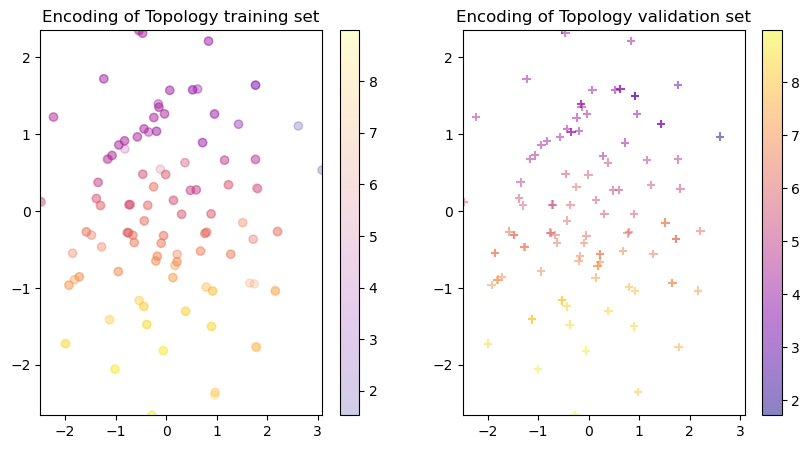

In [ ]:
plot_topopt_encoding(vae_model)

1
tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 4.9245]],
       device='cuda:0', grad_fn=<CatBackward0>)
1
tensor([[0.9999, 1.0000, 1.0000,  ..., 0.9999, 0.9995, 4.4675]],
       device='cuda:0', grad_fn=<CatBackward0>)
1
tensor([[1.0000, 0.9997, 1.0000,  ..., 1.0000, 1.0000, 6.5573]],
       device='cuda:0', grad_fn=<CatBackward0>)


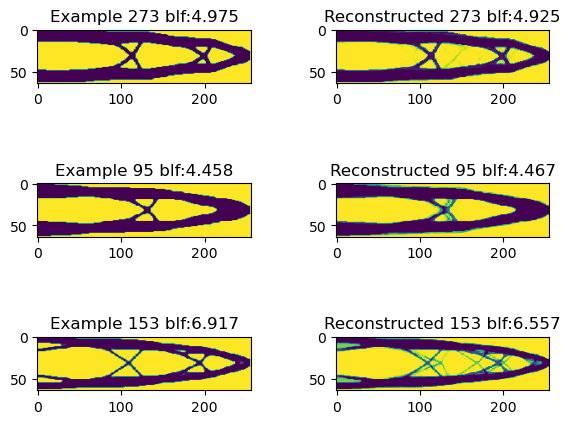

In [ ]:
n = 3

fig = plt.figure()
plt.axis('off') 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1)

np.random.seed(seed=6666) #for reproducibility
for i in range(1,n+1):
    fig.add_subplot(n, 2, 2*i-1) 
    idx = np.random.randint(0, len(design_vectors))

    
    design_vector = design_vectors[idx,:]
    image_vector = design_vector[:-1]
    blf_val = design_vector[-1]

    plt.imshow(image_vector.reshape(64,256))
    # plt.title("Example:"+ str(idx) + " blf:" +str(blf_val)) 
    plt.title("Example {0} blf:{1:.3f}".format(idx, blf_val)) 
    fig.add_subplot(n, 2, 2*i) 

    reconstructed_vector, mu, log_variance= vae_model(torch.tensor(design_vector.astype(np.float32)).to(device).unsqueeze(0))
    print(len(reconstructed_vector))
    print(reconstructed_vector)
    reconstructed_image = reconstructed_vector[0,:-1].detach().reshape(64,256).cpu()
    reconstructed_blf = reconstructed_vector[0,-1].detach().cpu().numpy()


    plt.imshow(reconstructed_image)
    #  "Epoch {0} | Mean training loss: {1:.3f} | Mean validation loss: {2:.3f}".format(
    #         i, np.mean(training_losses), np.mean(validation_losses)
    #     )
    plt.title("Reconstructed {0} blf:{1:.3f}".format(idx, reconstructed_blf)) 


np.random.seed(seed=None)

In [ ]:
saved_file_name = "vae1203.pth"  
torch.save(vae_model.state_dict(), saved_file_name)

# Load model parameters
reloaded_vae_model = VariationalAutoEncoder(
    Encoder(latent_dimensionality=4),
    Decoder(latent_dimensionality=2),
    latent_dimensionality=2).to(device)

reloaded_vae_model.load_state_dict(torch.load(saved_file_name))
reloaded_vae_model.eval()

VariationalAutoEncoder(
  (encoder): Encoder(
    (fc_1): Linear(in_features=16385, out_features=1000, bias=True)
    (fc_2): Linear(in_features=1000, out_features=100, bias=True)
    (fc_3): Linear(in_features=101, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (fc_1): Linear(in_features=2, out_features=100, bias=True)
    (fc_2): Linear(in_features=100, out_features=1000, bias=True)
    (fc_3): Linear(in_features=1000, out_features=16385, bias=True)
  )
  (loss): MSELoss()
)

In [ ]:
n = 10  # number of images per rows columns

# grid sampling in latent space
z = np.linspace(-3, 3, n)
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

# decode samples

ims = vae_model.decoder(torch.tensor(Z).float().to(device)).detach().cpu()

# plot
fig, axes = plt.subplots(n, n, figsize=(7, 7))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
count = 0
for k in range(0, ims.shape[0]):
    i, j = int(count / n), int(count % n)
    axes[i, j].imshow(ims[k, :-1].reshape(64,256))
    axes[i, j].axis("off")
    count += 1
plt.show()

Try to sample from the latent space

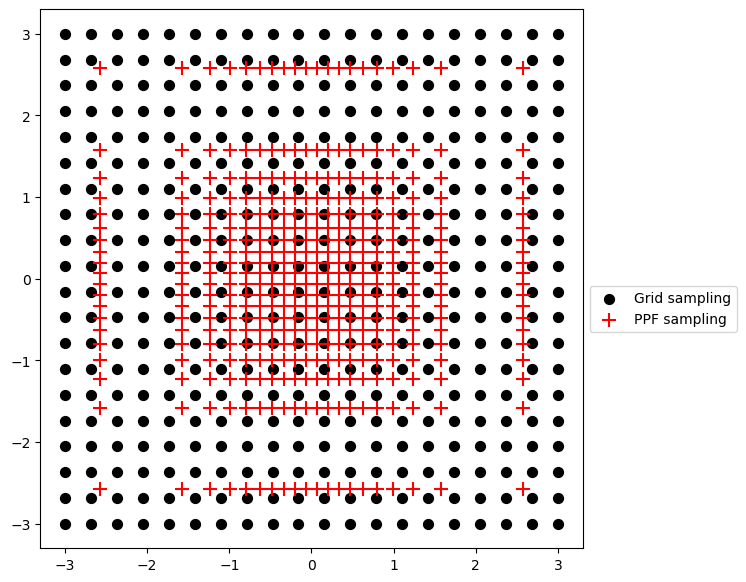

In [ ]:
plt.figure(figsize=(7, 7))

n = 20  # sampling resolution
# evenly-spaced grid sampling in latent space
z = np.linspace(-3, 3, n)
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

plt.scatter(Z[:, 0], Z[:, 1], s=50, c="black", label="Grid sampling")

z = scipy.stats.norm.ppf(np.linspace(0.005, 0.995, n))
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

plt.scatter(Z[:, 0], Z[:, 1], marker="+", s=100, c="red", label="PPF sampling")
plt.legend(fontsize=10, bbox_to_anchor=(1, 0.5))
plt.show()

Now, let's use this sampling scheme on the  VAE (with a higher resolution) and see what we get.

In [ ]:
n = 10  # number of images per rows columns

# grid sampling in latent space
z = scipy.stats.norm.ppf(np.linspace(0.005, 0.995, n))
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

# decode samples
ims = vae_model.decoder(torch.tensor(Z).float().to(device)).detach().cpu()
print(ims.size())
# plot
fig, axes = plt.subplots(n, n, figsize=(35, 35))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
count = 0
for k in range(0, ims.shape[0]):
    i, j = int(count / n), int(count % n)
    axes[i, j].imshow(ims[k,:-1].reshape(64,256))
    axes[i, j].axis("off")
    count += 1
plt.show()

torch.Size([100, 16385])


In [ ]:
n = 30
# number of images per rows columns

z = scipy.stats.norm.ppf(np.linspace(0.005, 0.995, n))
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T


# decode samples
ims = vae_model.decoder(torch.tensor(Z).float().to(device)).detach().cpu()

# plot
fig, axes = plt.subplots(n, n, figsize=(35, 35))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

blf_array_matlab = np.zeros((n,n))
blf_array_reconstructed = np.zeros((n,n))
count = 0

for k in tqdm(range(0, ims.shape[0])):
    print(k)
    i, j = int(count / n), int(count % n)
    ims_array = ims[k, :-1].reshape(64,256)
    axes[i, j].imshow(ims_array)
    axes[i, j].axis("off")
    reconstructed_blf = ims[k,-1]
    filename = "data/" + str(k)
    np.savetxt( filename +'.csv', ims_array, delimiter=',')
    blf_array_matlab[i,j] = octave.getblf(filename, nout = 1)
    blf_array_reconstructed[i,j] = reconstructed_blf
    # print(i,j,blf_array[i,j])
    count += 1
plt.show()
# print(blf_array)
# np.savetxt( "blf_arrays" +'.csv', blf_array, delimiter=',')




  0%|          | 0/900 [00:00<?, ?it/s]

0
    subsolv at line 175 column 32
    mmasub at line 167 column 39
    topBuck250_Column_MMA_BLF_calc at line 263 column 45
    getblf at line 24 column 21
    _pyeval at line 57 column 30

    subsolv at line 175 column 32
    mmasub at line 167 column 39
    topBuck250_Column_MMA_BLF_calc at line 263 column 45
    getblf at line 24 column 21
    _pyeval at line 57 column 30

    subsolv at line 175 column 32
    mmasub at line 167 column 39
    topBuck250_Column_MMA_BLF_calc at line 263 column 45
    getblf at line 24 column 21
    _pyeval at line 57 column 30

    subsolv at line 175 column 32
    mmasub at line 167 column 39
    topBuck250_Column_MMA_BLF_calc at line 263 column 45
    getblf at line 24 column 21
    _pyeval at line 57 column 30

    subsolv at line 175 column 32
    mmasub at line 167 column 39
    topBuck250_Column_MMA_BLF_calc at line 263 column 45
    getblf at line 24 column 21
    _pyeval at line 57 column 30

    subsolv at line 175 column 32
    mmasub at 

(-3.075829303548901, 3.0758293035489004)

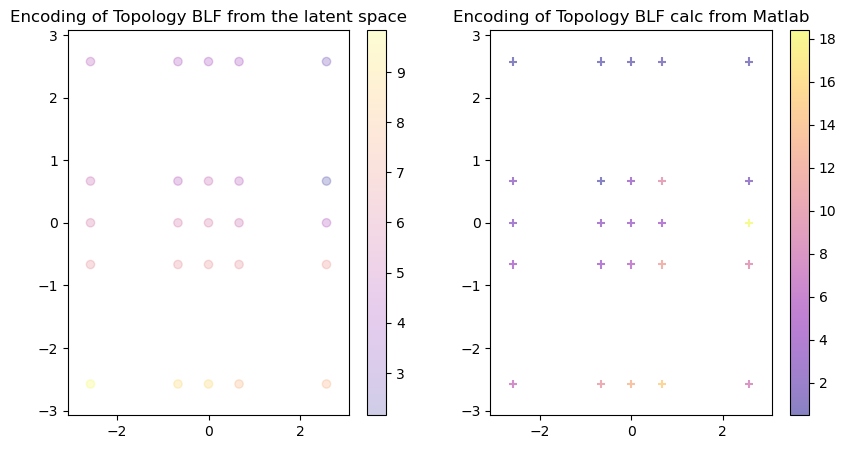

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Training data
ax[0].set_title(label="Encoding of Topology BLF from the latent space")

training_bbox = np.min(Z, axis=0), np.max(Z, axis=0)

scatter1 = ax[0].scatter(
    Z[:, 0],
    Z[:, 1],
    c= blf_array_reconstructed,
    alpha=0.2,
    cmap="plasma",
    label="Training",
)
plt.colorbar(scatter1)

# # MATLAB calc data.

ax[1].set_title(label="Encoding of Topology BLF calc from Matlab")


scatter2 = ax[1].scatter(
    Z[:, 0],
    Z[:, 1],
    c=blf_array_matlab,
    alpha=0.5,
    marker="+",
    cmap="plasma",
)
plt.colorbar(scatter2)

# ax[1].legend(*scatter.legend_elements(), title="blf", bbox_to_anchor=(1, 0.5))

# adjust such that both subplots have same bounds
ax[0].set_xlim(
    training_bbox[0][0]-0.5,
    training_bbox[1][0]+0.5,
)

ax[0].set_ylim(
    training_bbox[0][1]-0.5,
    training_bbox[1][1]+0.5
)

ax[1].set_xlim(
    training_bbox[0][0]-0.5,
    training_bbox[1][0]+0.5,
)

ax[1].set_ylim(
    training_bbox[0][1]-0.5,
    training_bbox[1][1]+0.5
)



In [ ]:
def get_all_VAE_encodings(model, dataloader):
    all_encoded = []
    all_blf = []
    for _ , input_vector in enumerate(dataloader):
        encoding = model.encoder(input_vector.to(device)).detach().cpu().numpy()
        print(encoding.shape)
        all_encoded.append(encoding)
        # print(input_vector.shape)
        all_blf.append(input_vector[:,-1])
        #all_labels.append(labels.numpy())

    all_encoded = np.concatenate(all_encoded)
    all_blf = np.concatenate(all_blf)

    return all_encoded , all_blf


# get bounding box
vae_encodings = get_all_VAE_encodings(vae_model, validation_dataloader)

print(len(vae_encodings[1]))
print(vae_encodings[:2])
x_min, y_min = np.min(vae_encodings[:2], axis=0)
x_max, y_max = np.max(vae_encodings[:2], axis=0)


n = 10
# number of images per rows columns

# grid sampling in latent space
z1 = np.linspace(0, 1, n) * (x_max - x_min) + x_min
z2 = np.linspace(0, 1, n) * (y_max - y_min) + y_min
Z1, Z2 = np.meshgrid(z1, z2)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

# decode samples
ims = vae_model.decoder(torch.tensor(Z).float().to(device)).detach().cpu()

# plot
fig, axes = plt.subplots(n, n, figsize=(70, 70))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
# blf_array = np.zeros((n,n))
count = 0
for k in range(0, ims.shape[0]):
    i, j = int(count / n), int(count % n)
    ims_array = ims[k, :].reshape(64,256)
    axes[i, j].imshow(ims_array)
    axes[i, j].axis("off")

    filename = str(k)
    np.savetxt( filename +'.csv', ims_array, delimiter=',')
    # blf_array[i,j] = octave.getblf(filename, nout = 1)
    # print(i,j,blf_array[i,j])
    count += 1
plt.show()
# print(blf_array)
# np.savetxt( "blf_arrays" +'.csv', blf_array, delimiter=',')

(64, 4)
(43, 4)
107
(array([[-1.8509861 , -0.5501773 , -2.4566114 , -4.198799  ],
       [-0.34338933,  1.0250397 , -2.6082618 , -4.023554  ],
       [ 0.8405622 ,  2.2063684 , -2.2422557 , -3.1775932 ],
       [ 1.7693619 ,  0.6696402 , -3.793208  , -4.8495755 ],
       [-1.7173932 , -0.8551914 , -2.4348838 , -4.210663  ],
       [ 1.769934  ,  1.634563  , -2.8787882 , -3.6329408 ],
       [-0.14105104,  1.3481493 , -2.2867062 , -3.4325786 ],
       [-0.7448649 , -0.2839919 , -4.0355926 , -4.7192254 ],
       [-0.20224594, -0.64901125, -4.347855  , -4.428938  ],
       [ 0.7932435 , -0.987476  , -4.2715626 , -4.9731793 ],
       [ 2.6001267 ,  0.96547604, -3.3317764 , -3.809328  ],
       [-0.18732266,  1.035671  , -2.915737  , -4.1047425 ],
       [-0.62836474, -0.4107722 , -4.2620044 , -4.6042595 ],
       [ 1.2798144 , -0.56256187, -4.2787175 , -4.843108  ],
       [-0.28192243, -2.6531987 , -2.969245  , -3.5663114 ],
       [ 0.91947985, -1.039296  , -4.0788484 , -4.8674774 ],
   

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 107) + inhomogeneous part.

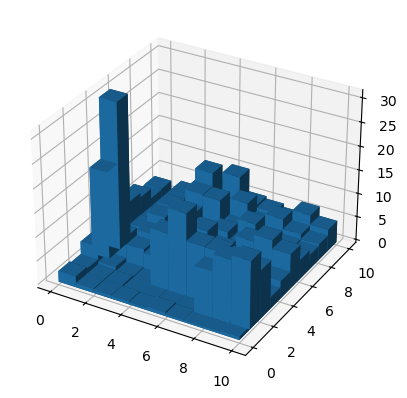

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

# np.random.seed(1234)
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
# A = np.random.randint(5, size=(25, 10))
A = blf_array

x = np.array([[i] * n for i in range(n)]).ravel() # x coordinates of each bar
y = np.array([i for i in range(n)] * n) # y coordinates of each bar

scatter_final = 

In [ ]:
print(x)
print(A.shape)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]
(10, 10)


In [ ]:
x = np.array([[i] * n for i in range(n)]).ravel() # x coordinates of each bar
y = np.array([i for i in range(n)] * n) # y coordinates of each bar

plt.scatter(x, y, c=blf_array, alpha=0.5)

In [ ]:
x = np.linspace(x_min, x_max, n)
y = np.linspace(y_min, y_max, n)
# z = np.array([i*i+j*j for j in y for i in x])

X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, A, 1000)

Clearly, the latent space is not as "nice" as the one produced by the VAE, i.e. most of the space contains little variations and/or garbage.